In [2]:
from IPython.display import display
from sklearn.model_selection import train_test_split
import numpy as np
import sklearn
import pandas as pd
import time
import matplotlib.pyplot as plt
import matplotlib
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
matplotlib.rc('figure', figsize=[10,5])
import matplotlib.pyplot as plt
plt.style.use(['seaborn'])

hr_df = pd.read_csv("C:\\Users\\kelle\\Downloads\\HR_Data\\aug_train.csv")

def plot_learning_curve(train_scores, val_scores, indices, title, inverse_x=False):
    plt.plot(indices, train_scores , "g-+", linewidth=2, label="train")
    plt.plot(indices, val_scores, "b-+", linewidth=2, label="validation")
    plt.title(title)
    plt.legend()
    plt.xlabel('Number of Training Instances Used')
    plt.grid(color='black', linestyle='-', linewidth=0.5, alpha=0.3)
    if inverse_x:
        plt.gca().invert_xaxis()
        
def plot_complexity(train_scores, val_scores, indices, title, inverse_x=False):
    plt.plot(indices, train_scores , "g-+", linewidth=2, label="train")
    plt.plot(indices, val_scores, "b-+", linewidth=2, label="validation")
    plt.title(title)
    plt.legend()
    plt.grid(color='black', linestyle='-', linewidth=0.5, alpha=0.3)
    plt.gca().invert_xaxis()
    
import matplotlib.pyplot as plt
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0,1,0,1])
    plt.legend()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone    

def stratFold(train_X_all, train_y_all, classifier, metric, average=None,
              fold=5):
    train_metric, val_metric, indices = [], [], []
    for m in range(100, len(train_X_all), 100):
        train_X = train_X_all[:m]
        train_y = train_y_all[:m]
        skfolds = StratifiedKFold(n_splits=fold)
        metric_list = []
        metric_list_train = []
        for train_index, test_index in skfolds.split(train_X, train_y):
            train_X_folds = train_X.iloc[train_index]
            train_y_folds = train_y.iloc[train_index]
            test_X_fold = train_X.iloc[test_index]
            test_y_fold = train_y.iloc[test_index]
            classifier.fit(train_X_folds.values, train_y_folds.values.ravel())
            train_y_folds_pred = classifier.predict(train_X_folds)
            test_y_fold_pred = classifier.predict(test_X_fold)
            if average:
                metric_list.append(metric(test_y_fold.values, test_y_fold_pred,
                                     average=average))
                metric_list_train.append(metric(train_y_folds.values, train_y_folds_pred, 
                                            average=average))
            else:
                metric_list.append(metric(test_y_fold.values, test_y_fold_pred))
                metric_list_train.append(metric(train_y_folds.values, train_y_folds_pred))
                
        test_avg = sum(metric_list)/len(metric_list)
        train_avg = sum(metric_list_train)/len(metric_list_train)
        val_metric.append(test_avg)
        train_metric.append(train_avg)
        indices.append(m)
    
    return train_metric, val_metric, indices

class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

hr_df['city']=hr_df['city'].astype(str)
hr_df['gender']=hr_df['gender'].astype(str)
hr_df['relevent_experience']=hr_df['relevent_experience'].astype(str)
hr_df['enrolled_university']=hr_df['enrolled_university'].astype(str)
hr_df['education_level']=hr_df['education_level'].astype(str)
hr_df['major_discipline']=hr_df['major_discipline'].astype(str)
hr_df['experience']=hr_df['experience'].astype(str)
hr_df['company_size']=hr_df['company_size'].astype(str)
hr_df['company_type']=hr_df['company_type'].astype(str)
hr_df['last_new_job']=hr_df['last_new_job'].astype(str)
hr_df = MultiColumnLabelEncoder(columns = ['city','gender','relevent_experience','enrolled_university','education_level','major_discipline','experience','company_size','company_type','last_new_job']).fit_transform(hr_df)



from sklearn.model_selection import StratifiedShuffleSplit
data_split = StratifiedShuffleSplit(n_splits=1 , test_size=0.3, random_state=30)
for train_ind, test_ind in data_split.split(hr_df, hr_df["target"]):
    strat_train_set = hr_df.loc[train_ind]
    strat_test_set = hr_df.loc[test_ind]
    
train_set = strat_train_set
test_set = strat_test_set

train_y = train_set[["target"]]
train_X = train_set.drop("target", axis=1)
test_y = test_set[["target"]]
test_X = test_set.drop("target", axis=1)

In [3]:
from sklearn.neural_network import MLPClassifier
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
neural_net = MLPClassifier()
neural_net.fit(train_X, train_y.values.ravel())

MLPClassifier()

414.29193472862244


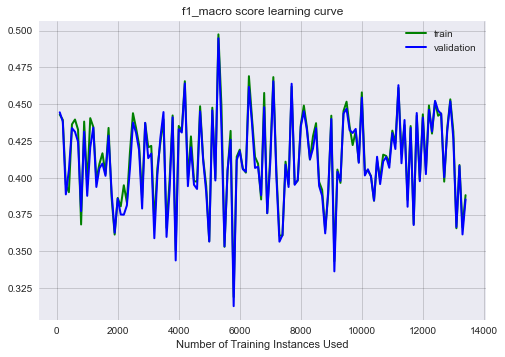

In [4]:
start = time.time()

from sklearn.metrics import f1_score
f1_scores = stratFold(train_X, train_y, neural_net, f1_score, average="macro")
plot_learning_curve(f1_scores[0], f1_scores[1], f1_scores[2], 
                    title="f1_macro score learning curve")

elapsed = (time.time() - start)
print(elapsed)

In [10]:
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
hr_train_predictions = neural_net.predict(train_X)
accuracy = accuracy_score(train_y, hr_train_predictions)
print(hr_train_predictions.mean())
print(accuracy)
print(roc_auc_score(train_y, hr_train_predictions))
print(classification_report(train_y, hr_train_predictions))

0.0087248322147651
0.751006711409396
0.50633917222884
              precision    recall  f1-score   support

         0.0       0.75      0.99      0.86     10066
         1.0       0.52      0.02      0.04      3344

    accuracy                           0.75     13410
   macro avg       0.64      0.51      0.45     13410
weighted avg       0.70      0.75      0.65     13410



MLPClassifier(hidden_layer_sizes=50) 0.4611121484027271


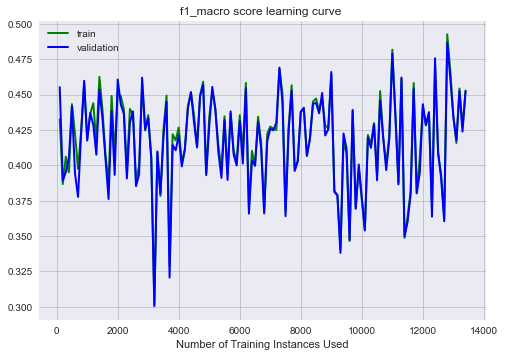

In [5]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'hidden_layer_sizes': [(50), (75), (100)],
    'alpha': [0.01, 0.001, 0.0001]
}
search_f1 = GridSearchCV(MLPClassifier(), param_grid, cv=10, 
                      scoring='f1_macro', n_jobs=-1)
search_f1.fit(train_X, train_y.values.ravel())
print(search_f1.best_estimator_, search_f1.best_score_)
from sklearn.metrics import f1_score
f1_scores = stratFold(train_X, train_y, search_f1.best_estimator_, f1_score, 
                      average='macro')
plot_learning_curve(f1_scores[0], f1_scores[1], f1_scores[2], 
                    title="f1_macro score learning curve ")